# **Final Experiments about Classic ML**

**Содержимое ноутбука:**

* Этот ноутбук содержит окончательные эксперименты по нелинейным моделям классическго машинного обучения
* Итоговый пайплайн в другом месте


**Мотивация:**
* Закрыть чекпоинт, проведя эксперименты с нелинейными моделями классическго ML
* Свести эксперименты с коллегами более однозначно
* Провести новые эксперименты по новым алгоритмам, которые не были проведены раньше


**В прошлых чекпоинтах** мы показали показали, что
* Снижение размерности посредством **Спектрального разложения(SVD)** - наилучший способ предподготовки данных, при несложных моделях. Сложилось стойкое ощущение, что другие способы предобработки выдают "слишком много информации", и обучающая способность моделей не может справиться с "обилием" информации.
* Можно построить эффективные MVP только при помощи **линейных моделей**. Да, линейных.
* Нелинейные модели классического ml, выдают лучшее качество, чем линейные.



**Выборки**

Мы с коллегами, пользуясь интуицией, по-разному брали выборки для обучения.
* Первый вариант: брать `репрезентативные выборки`
* Второй вариант: брыть `одинаковые доли классов`

Текущие размышления:
* Оказалось, что **нет универсального ответа. Решение подбирается под задачу**.
* Оба варианта адекватны и имеют свои преимущества.
* Есть ещё опции. Они все отражают одну из двух идей:
    * надо естесвенным образом брать данные репрезентативно
    * надо искусственно выравнивать дисбаланс классов


**Давайте проводить эксперименты**

In [1]:
!pip install gdown -q
!pip install catboost -q
!pip install lightgbm -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.8 MB/s eta 0:00:00


In [ ]:
DATA_FOLDER = "data/"

In [ ]:
import gdown

url = 'https://drive.google.com/uc?id=1MOjORo11C6A2FbXHkWxSbL-iB237Y_Zf'
save_name = DATA_FOLDER+'data_DEC24_SVD_128comp_5000.csv'
gdown.download(url, save_name, quiet=False)

url = 'https://drive.google.com/uc?id=18nNEnray3VFNhnySeRaJ6fSmOAiQ3Efp'
save_name = DATA_FOLDER + 'data_FEB25_SVD_eq_sample_128_5000.csv'
gdown.download(url, save_name, quiet=False)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(691)
random_state = 326

In [3]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from typing import List

### Common Functions

In [4]:
from sklearn.metrics import balanced_accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from typing import Tuple

def get_metrics(y_pred, y_true, rounding=8, verbouse=True, returns=False) -> Tuple:
    """Print/Return all metrics by predictions and true values"""

    if returns == True:
        verbouse = False

    acc = np.round(balanced_accuracy_score(y_pred, y_true), rounding)
    f1 = np.round(f1_score(y_pred, y_true, average="weighted"), rounding)

    y_true_binarized = label_binarize(y_true, classes=[0, 1, 2])
    y_pred_binarized = label_binarize(y_pred, classes=[0, 1, 2])

    # Расчет ROC-AUC для многоклассовой задачи
    auc_score = roc_auc_score(y_true_binarized, y_pred_binarized,
                            multi_class='ovr', average=None)

    roc_auc_metric = y.value_counts(sort=False, normalize=True) @ auc_score[::-1]
    roc_auc_metric = np.round(roc_auc_metric, rounding)
    gini = 2 * roc_auc_metric - 1
    gini = np.round(gini, rounding)

    if verbouse:
        print(f"Balanced accuracy: {acc}")
        print(f"F1-score: {f1}")
        print(f"roc_auc_score: {roc_auc_metric}")
        print(f"gini_score:{gini}")

    if returns:
        return acc, f1, roc_auc_metric, gini


In [28]:
def plot_confusion_matrixes(model1, model2, X_test, y_test):
    fig, ax = plt.subplots(1, 2, figsize=(14, 4))

    LABELS = ["Pneumonia", "Other", "Normal"]
    CMAP = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)

    ax[0].set_title("SVM rbf kernel")
    ax[1].set_title("Random Forest")

    disp_1 = ConfusionMatrixDisplay.from_estimator(model1, X_test, y_test, display_labels=LABELS, cmap=CMAP, normalize="true", ax=ax[0])
    disp_1.im_.set_clim(0, 1)
    disp_2 = ConfusionMatrixDisplay.from_estimator(model2, X_test, y_test, display_labels=LABELS, cmap=CMAP, normalize="true", ax=ax[1]);
    disp_2.im_.set_clim(0, 1)

### Set Save Results

In [6]:
# всегда берём 20% в тест
# 5001 - это тоже 5000
cols = ["model_name", "params", "sample_size", "sample_method", "balanced_accuracy", "f1-score", "roc_auc", "gini"]
exp_logs = pd.DataFrame(columns=cols)

SAMPLE_SIZE = 5000

In [7]:
def add_new_exp(log_storage: pd.DataFrame, new_row: List):
    """Add new row to experiments loggs from list"""
    cols = [
        "model_name", "params", "sample_size", "sample_method",
        "balanced_accuracy", "f1-score", "roc_auc", "gini"
    ]

    new_exp = pd.DataFrame(new_row).T
    new_exp.columns=cols

    log_storage = pd.concat([log_storage, new_exp], ignore_index=True)
    return log_storage

## Подход репрезентативной выборки

In [9]:
df_images = pd.read_csv("data_DEC24_SVD_128_5000.csv")

In [10]:
X, y = df_images.drop(columns="class"), df_images["class"]
SAMPLE_METHOD = "representative"

We have 3 classes:


|Label|Text Label|Desc|Has Bounding Box|
|:-|:-|:-|:-|
|0|Lung Opacity|Есть затемнение в лёгких, есть bounding box|Yes|
|1|No Lung Opacity / Not Normal|Нет затемнения в лёгких, нет bounding box, но есть патология|No|
|2|Normal|Здоровые лёгкие|No|

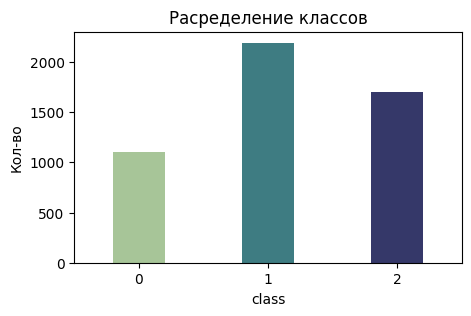

In [ ]:
plt.figure(figsize = (5, 3))
sns.countplot(x=y, hue=y, legend=False, palette='crest', width=0.4)
plt.title("Расределение классов")
plt.ylabel("Кол-во");

In [ ]:
y.value_counts(sort=False, normalize=True)

,proportion
class,
2,0.3408
1,0.4382
0,0.2210


### Models
Наилучшее качество среди классческих **испробованных** моделей покажет `SVC(kernel="rbf")` или `RandomForestClassifier`

Note: kernel="rbf" - это в данном контексте не гиперпараметр

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

In [26]:
NonLinearSVC = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', SVC(kernel = 'rbf', random_state=random_state))
])

NonLinearSVC.fit(X_train, y_train)

y_pred_SVC = NonLinearSVC.predict(X_test)

In [13]:
new_row = ["NonLinearSVC", "kernel = 'rbf'", SAMPLE_SIZE, SAMPLE_METHOD, *get_metrics(y_pred_SVC, y_test, returns=True)]
exp_logs = add_new_exp(exp_logs, new_row)

In [14]:
rfc = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', RandomForestClassifier(random_state=random_state))
])

rfc.fit(X_train, y_train)

y_pred_RFC = rfc.predict(X_test)

In [15]:
new_row = ["Random Forest", "", SAMPLE_SIZE, SAMPLE_METHOD, *get_metrics(y_pred_RFC, y_test, returns=True)]
exp_logs = add_new_exp(exp_logs, new_row)

### Compare models

In [ ]:
exp_logs

,model_name,params,sample_size,sample_method,balanced_accuracy,f1-score,roc_auc,gini
0,NonLinearSVC,kernel = 'rbf',5000,representative,0.621884,0.61835,0.676605,0.353211
1,Random Forest,,5000,representative,0.561821,0.567647,0.610826,0.221651


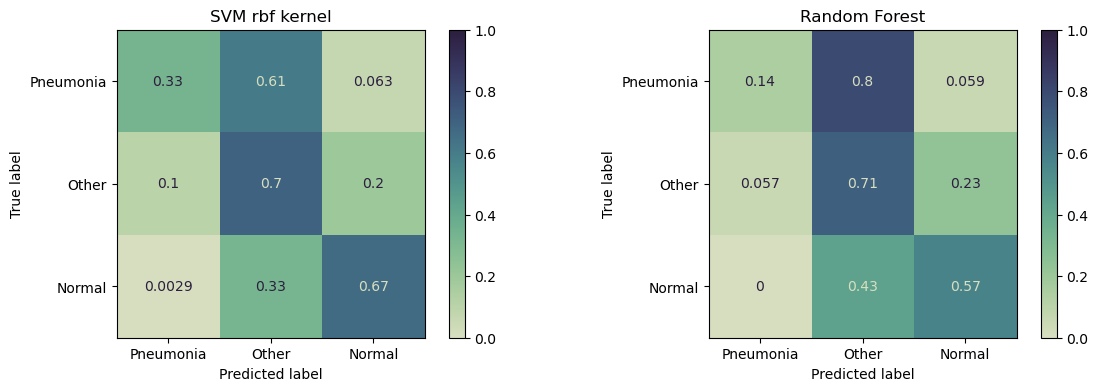

In [ ]:
plot_confusion_matrixes(NonLinearSVC, rfc, X_test, y_test)

Как интерпретировать 1 ячейку: **33% наблюдений с пневмонией был отнесён к классу пневмония**

#### Прикладные выводы

Как интерпретировать матрицу ошибок:
* по строкам в сумме получается 1.
* Правильная работа модели означает более яркую диагональ
* Обе модели плохо идентифицирует наличие пневмонии

#### Новые концептуальные выводы
* Без подбора параметров SVM('rbf') справляется лучше, чем случайный лес.


#### Возникшие гипотезы
* Если подбирать параметры в случайном лесу, может станет лучше, качество будет выше метода опорных векторов. В прошлых чекпоинтах подбирать параметры для опроных мекторов было относительно бесполезно

# Равномерная по классам выборка
Равная выборка + Без подбора параметров

In [30]:
SAMPLE_METHOD = "equal"

df_images = pd.read_csv("data_FEB25_SVD_eq_sample_128_5000.csv")
print(f"Размер выборки: {df_images.shape[0]}")

X, y = df_images.drop(columns="class"), df_images["class"]

Размер выборки: 5001


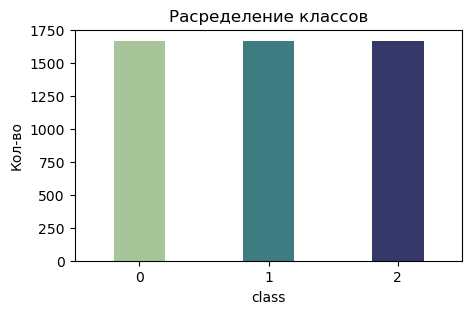

In [ ]:
plt.figure(figsize = (5, 3))
sns.countplot(x=y, hue=y, legend=False, palette='crest', width=0.4,)
plt.title("Расределение классов")
plt.ylabel("Кол-во");

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

## Models & Compare Models

In [32]:
NonLinearSVC = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', SVC(kernel = 'rbf', random_state=random_state))
])

NonLinearSVC.fit(X_train, y_train)

y_pred_SVC = NonLinearSVC.predict(X_test)

In [33]:
new_row = ["NonLinearSVC", "kernel = 'rbf'", SAMPLE_SIZE, SAMPLE_METHOD, *get_metrics(y_pred_SVC, y_test, returns=True)]
exp_logs = add_new_exp(exp_logs, new_row)

In [34]:
rfc = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', RandomForestClassifier(random_state=random_state))
])

rfc.fit(X_train, y_train)

y_pred_RFC = rfc.predict(X_test)

In [35]:
new_row = ["Random Forest", "", SAMPLE_SIZE, SAMPLE_METHOD, *get_metrics(y_pred_RFC, y_test, returns=True)]
exp_logs = add_new_exp(exp_logs, new_row)

In [ ]:
print("Модели без подбора параметров:")
exp_logs[(exp_logs.params == "") | (exp_logs.params == "kernel = 'rbf'")]

Модели без подбора параметров:


,model_name,params,sample_size,sample_method,balanced_accuracy,f1-score,roc_auc,gini
0,NonLinearSVC,kernel = 'rbf',5000,representative,0.621884,0.61835,0.676605,0.353211
1,Random Forest,,5000,representative,0.561821,0.567647,0.610826,0.221651
2,NonLinearSVC,kernel = 'rbf',5000,equal,0.584179,0.593288,0.692128,0.384255
3,Random Forest,,5000,equal,0.548633,0.576161,0.6734,0.346799


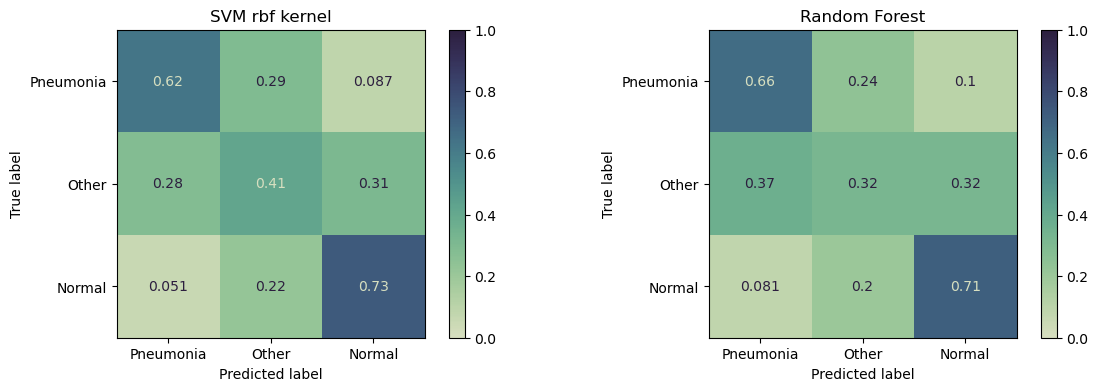

In [ ]:
plot_confusion_matrixes(NonLinearSVC, rfc, X_test, y_test)

#### Прикладные выводы
* Метод опорных векторов справился немного лучше, чем случайный лес без подбора параметров
* При равной выборке модели лучше определяют пневмонию, потому что в прошлый раз она была недопредставлена.


#### Новые концептуальные выводы
* В нашем случае брать равную выборку `оказалось скорее удачным решением`. В пропорциональной выборке было моделям сложнее всего определять пневмонию/пристуствие bbox-ов
* Зато такие модели плохо определяют наличие других патологий.

#### Возникшие гипотезы
* Было показвно, что модели могут иметь проблемы с определением пневмонии и других заболеваний. А случаи нормы определяются легко. **Возможно, стоит недопредставлять нормальные случаи, если мы обучаемся на выборке.**

## Эксперименты по подбору параметров
* Равная выборка + Подбор параметров для Случайного леса

* Для SVC подбирать параметры почти бесполезно

In [ ]:
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_features': [None, 'sqrt', 'log2'],
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=random_state), param_grid, cv=3, verbose=0)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
model = grid_search.best_estimator_


y_pred_RF = model.predict(X_test)

get_metrics(y_pred_RF, y_test, returns=True)

In [41]:
rfc = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', RandomForestClassifier(random_state=random_state, n_estimators=200, max_features=None))
])

rfc.fit(X_train, y_train)

y_pred_RFC = rfc.predict(X_test)

In [42]:
new_row = ["Random Forest", "n_estimators=200, max_features=None", SAMPLE_SIZE, SAMPLE_METHOD, *get_metrics(y_pred_RFC, y_test, returns=True)]
exp_logs = add_new_exp(exp_logs, new_row)

In [45]:
exp_logs

,model_name,params,sample_size,sample_method,balanced_accuracy,f1-score,roc_auc,gini
0,NonLinearSVC,kernel = 'rbf',5000,representative,0.621884,0.61835,0.676605,0.353211
1,Random Forest,,5000,representative,0.561821,0.567647,0.610826,0.221651
3,NonLinearSVC,kernel = 'rbf',5000,equal,0.584179,0.593288,0.692128,0.384255
4,Random Forest,,5000,equal,0.548633,0.576161,0.6734,0.346799
5,Random Forest,"n_estimators=200, max_features=None",5000,equal,0.563527,0.580365,0.680137,0.360274
6,Random Forest,"n_estimators=200, max_features=None",5000,representative,0.609948,0.59987,0.662796,0.325592


In [44]:
exp_logs.drop(exp_logs.index[2], inplace=True)

## Эксперименты с новыми алгоритмами

Про что рассказали на ML, то попробуем. Ансамбли.

In [ ]:
SAMPLE_METHOD = "equal"

df_images = pd.read_csv("data_FEB25_SVD_eq_sample_128_5000.csv")

X, y = df_images.drop(columns="class"), df_images["class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

Эксперимент с деревом. Оказался не очень удачным даже с подбором гиперпараметров.

In [48]:
dt = DecisionTreeClassifier(random_state=random_state)
dt.fit(X_train, y_train)

y_pred_DT = dt.predict(X_test)

print(get_metrics(y_pred_DT, y_test, returns=True))

new_row = ["Tree", "", SAMPLE_SIZE, SAMPLE_METHOD, *get_metrics(y_pred_DT, y_test, returns=True)]
exp_logs = add_new_exp(exp_logs, new_row)

(0.4497942, 0.44563095, 0.58494257, 0.16988514)


In [49]:
param_grid = {
    'max_depth': [5, 7, 10, 15, 20],
    'max_features': ['log2', 'sqrt', None]
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=326), param_grid, cv=3, scoring='balanced_accuracy', verbose=0)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_, grid_search.best_estimator_, grid_search.best_score_)
model = grid_search.best_estimator_


{'max_depth': 5, 'max_features': None} DecisionTreeClassifier(max_depth=5, random_state=326) 0.49946913205340165


In [50]:
dt = DecisionTreeClassifier(random_state=random_state, max_depth=5)
dt.fit(X_train, y_train)

y_pred_DT = dt.predict(X_test)

print(get_metrics(y_pred_DT, y_test, returns=True))

new_row = ["Tree", "max_depth=5", SAMPLE_SIZE, SAMPLE_METHOD, *get_metrics(y_pred_DT, y_test, returns=True)]
exp_logs = add_new_exp(exp_logs, new_row)

(0.50222311, 0.48679826, 0.61788869, 0.23577738)


In [51]:
exp_logs

,model_name,params,sample_size,sample_method,balanced_accuracy,f1-score,roc_auc,gini
0,NonLinearSVC,kernel = 'rbf',5000,representative,0.621884,0.61835,0.676605,0.353211
1,Random Forest,,5000,representative,0.561821,0.567647,0.610826,0.221651
2,NonLinearSVC,kernel = 'rbf',5000,equal,0.584179,0.593288,0.692128,0.384255
3,Random Forest,,5000,equal,0.548633,0.576161,0.6734,0.346799
4,Random Forest,"n_estimators=200, max_features=None",5000,equal,0.563527,0.580365,0.680137,0.360274
5,Random Forest,"n_estimators=200, max_features=None",5000,representative,0.609948,0.59987,0.662796,0.325592
6,Tree,,5000,equal,0.449794,0.445631,0.584943,0.169885
7,Tree,max_depth=5,5000,equal,0.502223,0.486798,0.617889,0.235777


**LGBM**

In [ ]:
df_images = pd.read_csv("data_DEC24_SVD_128_5000.csv")
X, y = df_images.drop(columns="class"), df_images["class"]
SAMPLE_METHOD = "representative"

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

In [71]:
X_train = X_train.drop('Unnamed: 0', axis=1)
X_test = X_test.drop('Unnamed: 0', axis=1)

In [55]:
LGBM = LGBMClassifier(random_state=random_state, verbose=0)
LGBM.fit(X_train, y_train)

y_pred_LGBM = LGBM.predict(X_test)

In [56]:
new_row = ["LGBM", "", SAMPLE_SIZE, SAMPLE_METHOD, *get_metrics(y_pred_LGBM, y_test, returns=True)]
exp_logs = add_new_exp(exp_logs, new_row)

**CatBoost**

In [57]:
CB = CatBoostClassifier(random_state=random_state, verbose=0)
CB.fit(X_train, y_train)

y_pred_CB = CB.predict(X_test)

In [58]:
new_row = ["CatBoost", "", SAMPLE_SIZE, SAMPLE_METHOD, *get_metrics(y_pred_CB, y_test, returns=True)]
exp_logs = add_new_exp(exp_logs, new_row)

In [ ]:
exp_logs

,model_name,params,sample_size,sample_method,balanced_accuracy,f1-score,roc_auc,gini
0,NonLinearSVC,kernel = 'rbf',5000,representative,0.621884,0.61835,0.676605,0.353211
1,Random Forest,,5000,representative,0.561821,0.567647,0.610826,0.221651
2,NonLinearSVC,kernel = 'rbf',5000,equal,0.584179,0.593288,0.692128,0.384255
3,Random Forest,,5000,equal,0.548633,0.576161,0.6734,0.346799
4,LGBM,,5000,representative,0.588613,0.592683,0.663194,0.326388
5,CatBoost,,5000,representative,0.590213,0.589888,0.664669,0.329338


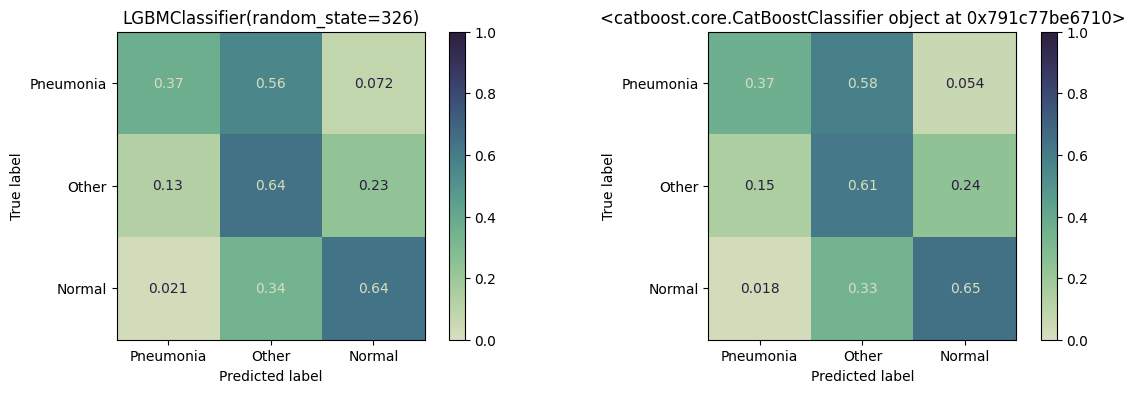

In [ ]:
plot_confusion_matrixes(LGBM, CB, X_test, y_test)

На репрезентативной выборке катбуст без подбора параметров показал себя неплохо, лучше LGBM, но хуже SVM. LGBM обучался пару секунд, это плюс. Катбуст обучался пару минут.

In [59]:
SAMPLE_METHOD = "equal"

df_images = pd.read_csv("data_FEB25_SVD_eq_sample_128_5000.csv")
print(f"Размер выборки: {df_images.shape[0]}")

X, y = df_images.drop(columns="class"), df_images["class"]

Размер выборки: 5001


In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

In [61]:
X_train = X_train.drop('Unnamed: 0', axis=1)
X_test = X_test.drop('Unnamed: 0', axis=1)

In [62]:
LGBM = LGBMClassifier(random_state=random_state, verbose=0)
LGBM.fit(X_train, y_train)

y_pred_LGBM = LGBM.predict(X_test)

In [63]:
new_row = ["LGBM", "", SAMPLE_SIZE, SAMPLE_METHOD, *get_metrics(y_pred_LGBM, y_test, returns=True)]
exp_logs = add_new_exp(exp_logs, new_row)

In [64]:
CB = CatBoostClassifier(random_state=random_state, verbose=0)
CB.fit(X_train, y_train)

y_pred_CB = CB.predict(X_test)

In [65]:
new_row = ["CatBoost", "", SAMPLE_SIZE, SAMPLE_METHOD, *get_metrics(y_pred_CB, y_test, returns=True)]
exp_logs = add_new_exp(exp_logs, new_row)

In [ ]:
exp_logs

,model_name,params,sample_size,sample_method,balanced_accuracy,f1-score,roc_auc,gini
0,NonLinearSVC,kernel = 'rbf',5000,representative,0.621884,0.61835,0.676605,0.353211
1,Random Forest,,5000,representative,0.561821,0.567647,0.610826,0.221651
2,NonLinearSVC,kernel = 'rbf',5000,equal,0.584179,0.593288,0.692128,0.384255
3,Random Forest,,5000,equal,0.548633,0.576161,0.6734,0.346799
4,LGBM,,5000,representative,0.588613,0.592683,0.663194,0.326388
5,CatBoost,,5000,representative,0.590213,0.589888,0.664669,0.329338
6,LGBM,,5000,equal,0.572607,0.581967,0.683865,0.36773
7,CatBoost,,5000,equal,0.558775,0.575056,0.676392,0.352784


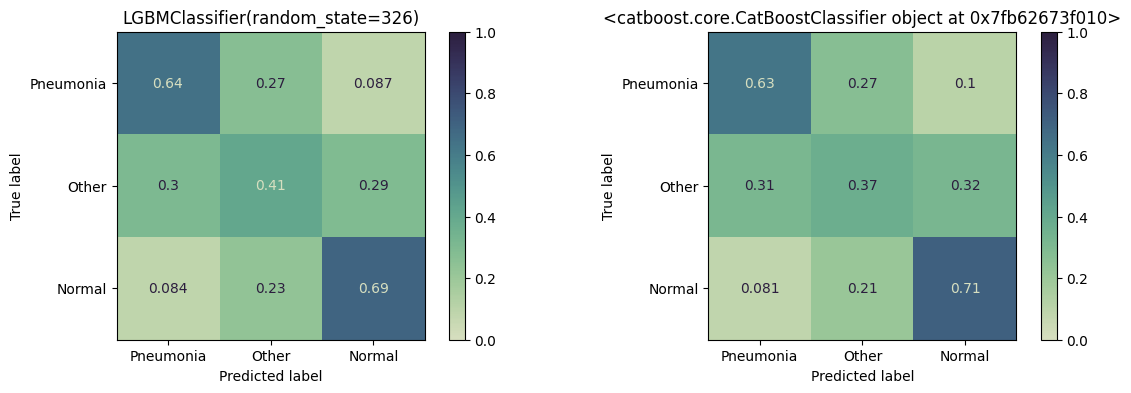

In [ ]:
plot_confusion_matrixes(LGBM, CB, X_test, y_test)

На равномерной выборке катбуст без подбора параметров приблизился к результату SVM, а LGBM оказался хуже катбуста, примерно как лес с параметрами. Дерево справилось хуже остальных моделей даже с подбором.

In [ ]:
print(LGBM.get_params())
print(CB.get_params())

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 326, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
{'random_state': 326}


**Подбор параметров для бустингов**

Подбор для равномерной выборки. Лучшим оказался LGBM, он по качеству плюс минус как SVM.

LGBM

In [ ]:
param_grid = {
    'learning_rate' : [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 10, 15],
    'n_estimators': [70, 100, 150]
}

grid_search = GridSearchCV(LGBMClassifier(random_state=326), param_grid, cv=3, scoring='balanced_accuracy', verbose=2)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_, grid_search.best_estimator_, grid_search.best_score_)
model = grid_search.best_estimator_


In [ ]:
model = LGBMClassifier(learning_rate= 0.05, max_depth=8, n_estimators=150, random_state=326)
model.fit(X_train, y_train)
y_pred_LGBM = model.predict(X_test)

print(get_metrics(y_pred_LGBM, y_test, returns=True))

new_row = ["LGBM", "learning_rate=0.05, max_depth=8, n_estimators=150", SAMPLE_SIZE, SAMPLE_METHOD, *get_metrics(y_pred_LGBM, y_test, returns=True)]
exp_logs = add_new_exp(exp_logs, new_row)

In [ ]:
model = LGBMClassifier(max_depth=7, n_estimators=150, random_state=326, verbosity=0)
model.fit(X_train, y_train)
y_pred_LGBM = model.predict(X_test)

new_row = ["LGBM", "learning_rate=0.1, max_depth=7, n_estimators=150", SAMPLE_SIZE, SAMPLE_METHOD, *get_metrics(y_pred_LGBM, y_test, returns=True)]
exp_logs = add_new_exp(exp_logs, new_row)

In [ ]:
param_grid = {
    'learning_rate' : [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 10],
    'n_estimators': [70, 100, 150]
}

grid_search = GridSearchCV(CatBoostClassifier(random_state=326), param_grid, cv=3, scoring='balanced_accuracy', verbose=2)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_, grid_search.best_estimator_, grid_search.best_score_)

CatBoost

In [68]:
model = CatBoostClassifier(learning_rate= 0.05, max_depth= 10, n_estimators= 150, random_state=326, verbose=0)
model.fit(X_train, y_train)
y_pred_CB = model.predict(X_test)

print(get_metrics(y_pred_CB, y_test, returns=True))

new_row = ["CatBoost", "learning_rate=0.05, max_depth=10, n_estimators=150", SAMPLE_SIZE, SAMPLE_METHOD, *get_metrics(y_pred_CB, y_test, returns=True)]
exp_logs = add_new_exp(exp_logs, new_row)

(0.5648892, 0.59731392, 0.68613651, 0.37227302)


In [ ]:
 exp_logs

,model_name,params,sample_size,sample_method,balanced_accuracy,f1-score,roc_auc,gini
0,NonLinearSVC,kernel = 'rbf',5000,representative,0.621884,0.61835,0.676605,0.353211
1,Random Forest,,5000,representative,0.561821,0.567647,0.610826,0.221651
2,NonLinearSVC,kernel = 'rbf',5000,equal,0.584179,0.593288,0.692128,0.384255
3,Random Forest,,5000,equal,0.548633,0.576161,0.6734,0.346799
4,LGBM,,5000,representative,0.588613,0.592683,0.663194,0.326388
5,CatBoost,,5000,representative,0.590213,0.589888,0.664669,0.329338
6,LGBM,,5000,equal,0.572607,0.581967,0.683865,0.36773
7,CatBoost,,5000,equal,0.558775,0.575056,0.676392,0.352784
10,LGBM,"learning_rate=0.05, max_depth=8, n_estimators=150",5000,equal,0.586608,0.597795,0.69511,0.390219
11,LGBM,"learning_rate=0.1, max_depth=7, n_estimators=150",5000,equal,0.572987,0.575517,0.680866,0.361733


Подбор для репрезентативной выборки. На мой взгяд, по совокупности метрик лучший тоже LGBM. Но всё ещё хуже SVM

LGBM

In [ ]:
param_grid = {
    'learning_rate' : [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 10, 15],
    'n_estimators': [70, 100, 150]
}

grid_search = GridSearchCV(LGBMClassifier(random_state=326), param_grid, cv=3, scoring='balanced_accuracy', verbose=0)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_, grid_search.best_estimator_, grid_search.best_score_)
model = grid_search.best_estimator_

In [72]:
model = LGBMClassifier(learning_rate=0.05, max_depth=10, n_estimators=200, random_state=326, verbose=0)
model.fit(X_train, y_train)
y_pred_LGBM = model.predict(X_test)

print(get_metrics(y_pred_LGBM, y_test, returns=True))

new_row = ["LGBM", "learning_rate=0.05, max_depth=10, n_estimators=200", SAMPLE_SIZE, SAMPLE_METHOD, *get_metrics(y_pred_LGBM, y_test, returns=True)]
exp_logs = add_new_exp(exp_logs, new_row)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
(0.59617722, 0.59972865, 0.66905924, 0.33811848)


CatBoost

In [73]:
model = CatBoostClassifier(learning_rate= 0.05, max_depth= 10, n_estimators= 200, random_state=326, verbose=0)
model.fit(X_train, y_train)
y_pred_CB = model.predict(X_test)

print(get_metrics(y_pred_CB, y_test, returns=True))

new_row = ["CatBoost", "learning_rate=0.05, max_depth=10, n_estimators=200", SAMPLE_SIZE, SAMPLE_METHOD, *get_metrics(y_pred_CB, y_test, returns=True)]
exp_logs = add_new_exp(exp_logs, new_row)

(0.60365023, 0.60142659, 0.65076435, 0.3015287)


In [74]:
exp_logs

,model_name,params,sample_size,sample_method,balanced_accuracy,f1-score,roc_auc,gini
0,NonLinearSVC,kernel = 'rbf',5000,representative,0.621884,0.61835,0.676605,0.353211
1,Random Forest,,5000,representative,0.561821,0.567647,0.610826,0.221651
2,NonLinearSVC,kernel = 'rbf',5000,equal,0.584179,0.593288,0.692128,0.384255
3,Random Forest,,5000,equal,0.548633,0.576161,0.6734,0.346799
4,Random Forest,"n_estimators=200, max_features=None",5000,equal,0.563527,0.580365,0.680137,0.360274
5,Random Forest,"n_estimators=200, max_features=None",5000,representative,0.609948,0.59987,0.662796,0.325592
6,Tree,,5000,equal,0.449794,0.445631,0.584943,0.169885
7,Tree,max_depth=5,5000,equal,0.502223,0.486798,0.617889,0.235777
8,LGBM,,5000,representative,0.588613,0.592683,0.663194,0.326388
9,CatBoost,,5000,representative,0.590213,0.589888,0.664669,0.329338


Лучшие модели на равномерной выборке: LGBM и SVC

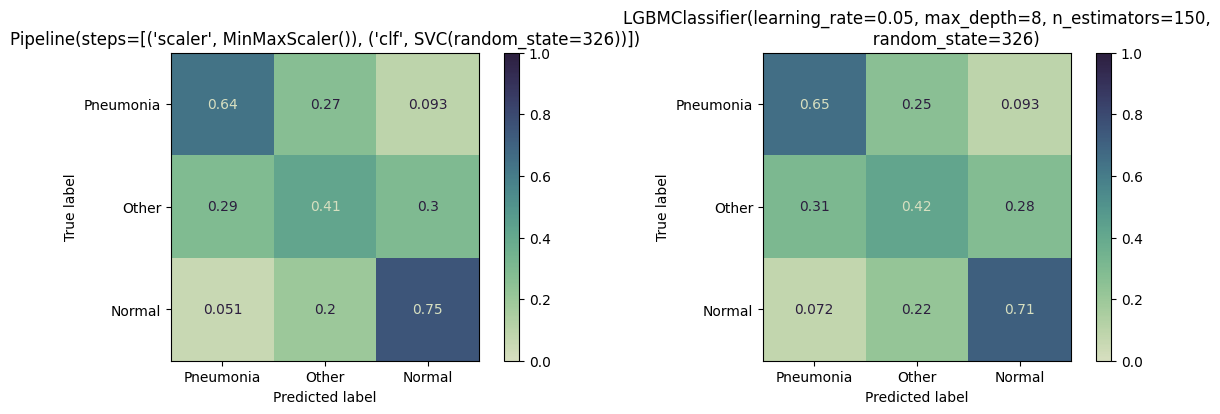

In [ ]:
plot_confusion_matrixes(NonLinearSVC, LGBM, X_test, y_test)